## [BUG] Seach optimal augmentation intensity by $\mu$ (minimal mutual information)

In [1]:
import os
os.chdir("/home1/quanquan/code/landmark/code/tproj")
assert os.getcwd() == "/home1/quanquan/code/landmark/code/tproj"

# The MI values are not accurate

In [2]:
import numpy as np
mi_mean = [0.58855864,0.9689842,0.88423108,0.41595766,0.93467499,0.87520715
            ,0.75355031,0.69097756,0.70706193,0.9617875,0.95781572,0.96094506
            ,0.98639255,0.89073955,0.96499311,0.71407015,0.93329412,0.91891464
            ,0.7271314]
np.array(mi_mean).mean()

0.8334361747368421

In [4]:
import cv2
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
# from scipy.misc import imread
import numpy as np
import cv2
from skimage.exposure import histogram
from scipy.stats import entropy
import matplotlib
from tutils import tfilename
from PIL import Image
import torchvision.transforms.functional as F
from scipy.stats import norm
matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from skimage.filters.rank import entropy
# from scipy.stats import entropy
from skimage.morphology import disk
from tqdm import tqdm
from torchvision.utils import save_image
import torch

mi_mean = [0.58855864,0.9689842,0.88423108,0.41595766,0.93467499,0.87520715
            ,0.75355031,0.69097756,0.70706193,0.9617875,0.95781572,0.96094506
            ,0.98639255,0.89073955,0.96499311,0.71407015,0.93329412,0.91891464
            ,0.7271314]
mi_std = [0.26388173,0.12006105,0.12696776,0.31245908,0.10358765,0.20422783
            ,0.21599622,0.18820669,0.19157507,0.13725611,0.11465392,0.12241823
            ,0.11602296,0.19213057,0.09218982,0.18752875,0.1210562, 0.1017045
            ,0.28287337]

miself_mean = [2.51138927,3.18064627,3.1936682,2.11334156,3.26182041,2.72902131
            ,2.16312098,1.94328915,2.01532239,3.26112403,3.20813622,3.16552408
            ,3.12697808,2.64613941,3.25124197,1.97482131,3.206975,3.22484813
            ,2.66378744]
miself_std = [0.46076691,0.30574453,0.2845213,0.48100281,0.24713011,0.75816679
,0.75060892,0.65067037,0.6793318, 0.23704422,0.36165119,0.38236706
,0.30267382,0.60297583,0.24602729,0.60459519,0.21163927,0.24409171
,0.47145102]

entr_mean = [4.32922599,4.94955578,4.9402223,4.13369406,5.02937445,4.46131056
            ,4.12397278,4.07084514,4.08404715,4.8864486, 4.87044201,4.79871701
            ,4.7067016, 4.29701387,4.94452249,4.05091702,5.03718015,5.01795204
            ,4.53197619]
entr_std = [0.32104817,0.36015503,0.25001072,0.34826474,0.22153489,0.53958994
,0.44612867,0.39377246,0.4095514, 0.27827981,0.33560316,0.348146
,0.33046936,0.41912717,0.26862784,0.38550231,0.17205685,0.20877866
,0.32103766]

mre = [1.399, 1.5526,1.7562,2.9915 , 1.7145, 1.9027,
       1.8260, 1.3118, 1.1585, 4.4261, 2.2153, 2.8174,
       1.5348, 1.9849, 1.3075, 1.8713,1.5415, 3.7358,
       2.3073]
mre2 =[1.6767,1.7246,2.2157,2.5067,1.9819,2.2091,
       1.7173,1.3327,1.6392,2.2740,1.6451,1.7791,
       1.5442,1.7209,1.8208,2.9706,1.8948,1.9768,
       2.1830]

def get_fea(patch):
    fea = np.zeros((256,))
    hist, idx = histogram(patch, nbins=256)
    for hi, idi in zip(hist, idx):
        # print(hi, idi, i, j)
        fea[idi] = hi
    return fea

def _tmp_fn2(landmark_id, alpha):
    """ augment and crop patch (different from _tmp_fn() ) """
    from datasets.ceph.ceph_ssl import Test_Cephalometric
    pth = '/home1/quanquan/datasets/Cephalometric/'
    testset = Test_Cephalometric(pth, mode="Train")
    # Process: lm 0, 3, 7
    lms = testset.ref_landmarks(114)

    dirname = '/home1/quanquan/datasets/Cephalometric/RawImage/TrainingData/'

    params_list = []
    for i in range(150):
        i += 1
        # i = 115
        # landmark_id = 3
        
        im_name = f'{i:03d}.bmp'
        im = cv2.imread(dirname + im_name, cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (384, 384))

        lm = lms[landmark_id]  # [168, 163]
        ps_half = 32
        patch = im[lm[1] - ps_half:lm[1] + ps_half, lm[0] - ps_half:lm[0] + ps_half]
        # save image patch
        # save_image(torch.Tensor(patch) / 255, f"paper_mi/saved_patches/im{i:03d}_lm{landmark_id}_patch.png")
        # continue
        fea1 = get_fea(patch)
        im = Image.fromarray(im)

        # print("=============================")
        cj_brightness = 1.
        cj_contrast = 1.
        params1 = [0, 0]
        for i in range(100):
            im_aug = F.adjust_brightness(im, cj_brightness)
            im_aug = F.adjust_contrast(im_aug, cj_contrast)
            im_aug = np.array(im_aug)
            # cv2.imwrite("patch2.jpg", patch_aug)
            patch_aug = im_aug[lm[1] - ps_half:lm[1] + ps_half, lm[0] - ps_half:lm[0] + ps_half]
            fea2 = get_fea(patch_aug)
            # mi0 = mutual_info_score(fea1.copy(), fea1.copy())
            mi = mutual_info_score(fea1, fea2)
            print(f"entr: {entr_mean[landmark_id]}, br: {cj_brightness}, ct: {cj_contrast}, mi:", mi, mi_mean[landmark_id] - mi_std[landmark_id]) # mi0
            cj_brightness += 0.03
            cj_contrast += 0.04
            if mi < mi_mean[landmark_id] * alpha:  # - mi_std[landmark_id]:
                break
            params1 = [cj_brightness, cj_contrast]
        # print("=============================")

        cj_brightness = 1
        cj_contrast = 1
        params2 = [0, 0]
        for i in range(100):
            im_aug = F.adjust_brightness(im, cj_brightness)
            im_aug = F.adjust_contrast(im_aug, cj_contrast)
            im_aug = np.array(im_aug)
            # cv2.imwrite("patch2.jpg", patch_aug)
            patch_aug = im_aug[lm[1] - ps_half:lm[1] + ps_half, lm[0] - ps_half:lm[0] + ps_half]
            fea2 = get_fea(patch_aug)

            # mi0 = mutual_info_score(fea1.copy(), fea1.copy())
            mi = mutual_info_score(fea1, fea2)
            print(f"entr: {entr_mean[landmark_id]}, br: {cj_brightness}, ct: {cj_contrast}, mi:", mi, mi_mean[landmark_id] - mi_std[landmark_id])  # mi0
            cj_brightness -= 0.03
            cj_contrast -= 0.04
            if mi < mi_mean[landmark_id] * alpha:  # - mi_std[landmark_id]:
                break
            params2 = [cj_brightness, cj_contrast]
        # print("=============================")
        params_list.append(params1 + params2)
        # import ipdb; ipdb.set_trace()

    params_list = np.array(params_list)
    mean_values = params_list.mean(axis=0)
    return mean_values

dd = _tmp_fn2(1,2)
print(dd)

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 
entr: 4.94955578, br: 1.0, ct: 1.0, mi: 3.5279172654652053 0.84892315
entr: 4.94955578, br: 1.03, ct: 1.04, mi: 2.070069696659652 0.84892315
entr: 4.94955578, br: 1.06, ct: 1.08, mi: 1.8209688999764961 0.84892315
entr: 4.94955578, br: 1, ct: 1, mi: 3.5279172654652053 0.84892315
entr: 4.94955578, br: 0.97, ct: 0.96, mi: 2.156461507851462 0.84892315
entr: 4.94955578, br: 0.94, ct: 0.9199999999999999, mi: 2.0695477858610873 0.84892315
entr: 4.94955578, br: 0.9099999999999999, ct: 0.8799999999999999, mi: 1.9713588947638045 0.84892315
entr: 4.94955578, br: 0.8799999999999999, ct: 0.8399999999999999, mi: 1.911237836037555 0.84892315
entr: 4.94955578, br: 1.0, ct: 1.0, mi: 3.411762589433137 0.84892315
entr: 4.94955578, br: 1.03, ct: 1.04, mi: 1.7236693105490695 0.84892315
entr: 4.94955578, br: 1, ct: 1, mi: 3.411762589433137 0.84892315
entr: 4.94955578, br: 0.97, ct: 0.96, mi: 1.8966420401934603 0.84892315
en

In [4]:
from tqdm import tqdm
ALPHA = 2

def process():
    new_entr = np.load('./cache/entr_values_384.npy')
    new_entr = new_entr.mean(axis=0)
    print(new_entr)
    res_list_med = []
    res_list_high = []

    for i in tqdm(range(19)):
        params = _tmp_fn2(i, alpha=ALPHA)
        res_d = {
            "index": i,
            "mi_mean": mi_mean[i],
            "mi_std": mi_std[i],
            "miself_mean": miself_mean[i],
            "miself_std": miself_std[i],
            "entr_mean": entr_mean[i],
            "entr_std": entr_std[i],
            "cj_br_ceil": params[0],
            "cj_ct_ceil": params[1],
            "cj_br_floor": params[2],
            "cj_ct_floor": params[3],
            "new_entr": new_entr[i],
            'mre_lm': mre[i],
            'mre_lm2': mre2[i],
        }
        
        if entr_mean[i] < 4.5:
            res_list_med.append(res_d)
        elif entr_mean[i] >= 4.5:
            res_list_high.append(res_d)
        # print(res_d)
    np.save(f"./cache/optimal_brct_im2_alpha{ALPHA}_med.npy", res_list_med)
    np.save(f"./cache/optimal_brct_im2_alpha{ALPHA}_high.npy", res_list_high)

In [5]:
process()

  0%|          | 0/19 [00:00<?, ?it/s]

[5.03954923 6.3315928  6.4256296  4.31938822 5.88861954 5.74528671
 5.30298577 5.90808298 5.49401018 5.89299394 6.51238883 6.17841545
 4.59100621 4.72441992 4.41810766 4.74404991 6.05747673 5.06121568
 6.09864964]
The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


  5%|▌         | 1/19 [00:08<02:24,  8.02s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 11%|█         | 2/19 [00:11<01:31,  5.36s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 16%|█▌        | 3/19 [00:16<01:22,  5.15s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 21%|██        | 4/19 [00:23<01:31,  6.11s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 26%|██▋       | 5/19 [00:27<01:13,  5.25s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 32%|███▏      | 6/19 [00:32<01:04,  4.94s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 37%|███▋      | 7/19 [00:37<01:00,  5.02s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 42%|████▏     | 8/19 [00:43<00:58,  5.33s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 47%|████▋     | 9/19 [00:48<00:53,  5.38s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 53%|█████▎    | 10/19 [00:52<00:44,  4.92s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 58%|█████▊    | 11/19 [00:56<00:35,  4.47s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 63%|██████▎   | 12/19 [00:59<00:28,  4.13s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 68%|██████▊   | 13/19 [01:02<00:22,  3.70s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 74%|███████▎  | 14/19 [01:05<00:17,  3.51s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 79%|███████▉  | 15/19 [01:08<00:13,  3.35s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 84%|████████▍ | 16/19 [01:12<00:11,  3.69s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 89%|████████▉ | 17/19 [01:16<00:07,  3.71s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


 95%|█████████▍| 18/19 [01:20<00:03,  3.74s/it]

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 


100%|██████████| 19/19 [01:25<00:00,  4.51s/it]


In [23]:
ALPHA=0.4
res = np.load(f'./cache/optimal_brct_im2_alpha{ALPHA}_med.npy', allow_pickle=True)
ares1 = np.array([r['cj_br_ceil'] for r in res])
ares2 = np.array([r['cj_br_floor'] for r in res])
print(ares1.mean(), ares2.mean())
res = np.load(f'./cache/optimal_brct_im2_alpha{ALPHA}_high.npy', allow_pickle=True)
ares1 = np.array([r['cj_br_ceil'] for r in res])
ares2 = np.array([r['cj_br_floor'] for r in res])
print(ares1.mean(), ares2.mean())

2.330549999999998 0.4526499999999992
2.3256727272727256 0.4312727272727267


1.5 - 1.19
1.3 - 1.27
1.2 - 1.32
1.1 - 1.38 
1.0 - 1.45
0.9 - 1.53  
0.8 - 1.62 
0.7 - 1.73


In [ ]:
# > 4.5 (high)
2.0 - 1.00
1.5 - 1.15
1.4 - 1.18
1.3 - 1.23
1.2 - 1.28
1.1 - 1.34
1.0 - 1.41
0.9 - 1.49
0.8 - 1.58

# < 4.5 (medium)
2.0 
1.3 - 1.33
1.2 - 1.38
1.1 - 1.44
1.0 - 1.50


0     2.580
1     2.500
2     2.460
3     2.420
4     2.390
5     2.346
6     2.349
7     2.340
8     2.348
9     2.340
10    2.330
11    2.344
12    2.460
13    2.800
Name: mre, dtype: float64


<AxesSubplot:xlabel='alpha', ylabel='mre'>

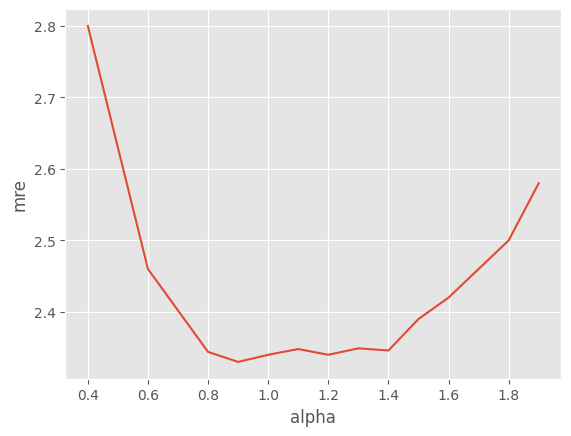

In [22]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

data =pd.read_csv("./paper_mi/mre_aug.csv")
data
print(data['mre'])
sns.lineplot(data=data, x="alpha", y="mre")

In [14]:
# [1.0484     1.06453333 0.9266     0.90213333]
landmark_id = 1

from datasets.ceph.ceph_ssl import Test_Cephalometric
pth = '/home1/quanquan/datasets/Cephalometric/'
testset = Test_Cephalometric(pth, mode="Train")
# Process: lm 0, 3, 7
lms = testset.ref_landmarks(114)

dirname = '/home1/quanquan/datasets/Cephalometric/RawImage/TrainingData/'

params_list = []
for i in range(50):
    i += 1
    # i = 115
    # landmark_id = 3

    im_name = f'{i:03d}.bmp'
    im = cv2.imread(dirname + im_name, cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im, (384, 384))

    lm = lms[landmark_id]  # [168, 163]
    ps_half = 32
    patch = im[lm[1] - ps_half:lm[1] + ps_half, lm[0] - ps_half:lm[0] + ps_half]
    # save image patch
    # save_image(torch.Tensor(patch) / 255, f"paper_mi/saved_patches/im{i:03d}_lm{landmark_id}_patch.png")
    # continue
    fea1 = get_fea(patch)
    im = Image.fromarray(im)

    # print("=============================")
    # cj_brightness_all = np.linspace(0.9266, 1.0484, 4)
    # cj_contrast_all = np.linspace(0.902133, 1.064533, 4)
    # cj_brightness_all = np.linspace(0.8266, 1.6484, 4)
    # cj_contrast_all = np.linspace(0.702133, 1.664533, 4)
    cj_brightness_all = np.linspace(0.9966, 1.0484, 4)
    cj_contrast_all = np.linspace(0.992133, 1.004533, 4)
    
    params1 = [0, 0]
    aug_id = 0
    for cj_brightness in cj_brightness_all:
        for cj_contrast in cj_contrast_all:
            im_aug = F.adjust_brightness(im, cj_brightness)
            im_aug = F.adjust_contrast(im_aug, cj_contrast)
            im_aug = np.array(im_aug)
            # cv2.imwrite("patch2.jpg", patch_aug)
            patch_aug = im_aug[lm[1] - ps_half:lm[1] + ps_half, lm[0] - ps_half:lm[0] + ps_half]
            save_image(torch.Tensor(patch_aug) / 255, f"paper_mi/auged_lack_patches/im{i:03d}_lm{landmark_id}_aug{aug_id:03d}_patch.png")
            aug_id += 1
    

The sizes are set as  [384, 384]
Initializing Datasets: (split:'Train') (len:(150)) 
